# <center> Forecasting utilizando redes recurrentes</center>

## Librerias

In [8]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import ExponentialLR

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funciones

In [10]:
#Creamos datos de la forma input, output
def create_sequences(serie, ventana=2,pred=1):
    x = []
    y = []
    i=0
    while(i<len(serie)):
    #for i in range(len(serie)):
        idx = i+ventana+pred
        if(idx >= len(serie)):
            break
        else:
            #Input: n observaciones pasadas
            x.append(serie[i:(i+ventana)])
            #Output: observacion en el timepo t+1     
            y.append(serie[i+ventana:(i+ventana+pred)])         #Output: observacion en el timepo t+1
        i=i+pred

    return torch.from_numpy(np.array(x)).float(), torch.from_numpy(np.array(y)).float()

In [11]:
#Funcion de importacion de datos y division de los conj. necesarios
def week_databases(path):
    #Importamos los datos
    categoria = pd.read_csv(path, parse_dates=["fecha_hechos"])
    #categoria.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
    categoria.index = pd.DatetimeIndex(categoria.fecha_hechos)
    
    categoria_x_sem = categoria.resample("W", on = "fecha_hechos").size()
    ts_train_categoria=categoria_x_sem[categoria_x_sem.index<'2021-06']
    ts_valid_categoria= categoria_x_sem[categoria_x_sem[categoria_x_sem.index>='2021-05'] &
                                        categoria_x_sem[categoria_x_sem.index< "2022-06"]]
    ts_test_categoria = categoria_x_sem[categoria_x_sem.index>='2022-05']

    return ts_train_categoria,ts_valid_categoria,ts_test_categoria

In [12]:
#Funcion de importacion de datos y division de los conj. necesarios
def hour_databases(path):
    #Importamos los datos
    categoria = pd.read_csv(path, parse_dates=["fecha_hechos"])
    #categoria.drop(columns=["fecha_hechos.2", "fecha_hechos.1"], inplace=True)
    categoria.index = pd.DatetimeIndex(categoria.fecha_hechos)
    
    categoria_x_sem = categoria.resample("H", on = "fecha_hechos").size()
    ts_train_categoria=categoria_x_sem[categoria_x_sem.index<'2021-06']
    ts_valid_categoria= categoria_x_sem[categoria_x_sem[categoria_x_sem.index>='2021-05'] &
                                        categoria_x_sem[categoria_x_sem.index< "2022-06"]]
    ts_test_categoria = categoria_x_sem[categoria_x_sem.index>='2022-05']

    return ts_train_categoria,ts_valid_categoria,ts_test_categoria

In [13]:
def prepare_dataloaders(ts_train_categoria,ts_valid_categoria,ts_test_categoria,
                         batch_size = 1,dim_input=1,dim_output=1):
    #Estandarizacion max-min de los datos respecto al conj. de entrenamiento   
    scaler = MinMaxScaler(feature_range=(-1, 1))
    sca_train_categoria = scaler.fit_transform(ts_train_categoria.values.reshape(-1, 1))
    sca_valid_categoria = scaler.transform(ts_valid_categoria.values.reshape(-1,1))
    sca_test_categoria = scaler.transform(ts_test_categoria.values.reshape(-1,1))
    
    #Creacion datos de la forma  input, output
    X_train, y_train = create_sequences(sca_train_categoria.reshape(len(sca_train_categoria)), dim_input,dim_output)
    X_val, y_val = create_sequences(sca_valid_categoria.reshape(len(sca_valid_categoria)), dim_input,dim_output)
    X_test, y_test = create_sequences(sca_test_categoria.reshape(len(sca_test_categoria)), dim_input,dim_output)
    
    X_train_tensor = TensorDataset(X_train, y_train)
    X_train_dataloader = DataLoader(X_train_tensor, shuffle = False, batch_size=batch_size)
    X_train, y_train = [], []

    X_val_tensor = TensorDataset(X_val, y_val)
    X_val_dataloader = DataLoader(X_val_tensor, shuffle = False, batch_size=batch_size)
    X_val, y_val = [], []
    
    X_test_tensor = TensorDataset(X_test, y_test)
    X_test_dataloader = DataLoader(X_test_tensor, shuffle = False, batch_size=batch_size)
    X_test, y_test = [], []
    
    return X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler

### Arquitecturas

In [14]:
class CNN1d(nn.Module):
    def __init__(self,
               dim_emb = 1,
               tam_filtros = [5, 4, 3, 2],
               num_filtros = [100, 100, 100, 100],
               salida_capas_FC = [],
               num_clases = 1,
               dropout = 0.5,
               activacion = 'relu'):
        
        super(CNN1d, self).__init__()
        # ==========================================================================
        # Preparación de embeddings
        self.dim_emb = dim_emb

        # ==========================================================================
        # Capa de convolución
        self.conv1d_list = nn.ModuleList([nn.Conv1d(in_channels  = self.dim_emb, 
                                                    out_channels = num_filtros[i], 
                                                    kernel_size = tam_filtros[i]) 
                                          for i in range(len(tam_filtros))])

        # ==========================================================================
        # Capa Fully-connected con BachNormalization y Dropout
        # self.fc = nn.Linear(np.sum(num_filtros),num_clases)

        self.BN_list = nn.ModuleList([nn.BatchNorm1d(nod) for nod in salida_capas_FC])

        if activacion == 'relu':
            self.activation = nn.ReLU()
        elif activacion == 'tanh':
            self.activation = nn.Tanh()

        SC_FC = salida_capas_FC
        SC_FC.insert(0,np.sum(num_filtros))
        SC_FC.append(num_clases)


        # Capa para preparar convolución
        self.fc_list = nn.ModuleList([nn.Linear(SC_FC[i], SC_FC[i+1]) for i in range(len(SC_FC)-1)])
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
          
        '''
           Estafunción realiza el paso fordward de la CNN
        '''    
        # Convoluciones y ReLu: #
        #x = x.float()
        x_conv_list = [F.relu(conv1d(x)) for conv1d in self.conv1d_list]

        # Max pooling
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[1]) for x_conv in x_conv_list]

        # Concatenamos Max pooling como input de Fully-connected
        x_fc = torch.cat([x_pool.squeeze(dim=1) for x_pool in x_pool_list], dim=0)

        # Fully-connected 
        n = len(self.BN_list)
        x_fc = self.fc_list[0](self.dropout(x_fc))
        
        for i in range(n):
            x_fc = self.activation(x_fc)
            x_fc = self.BN_list[i](x_fc)
            x_fc = self.fc_list[i+1](x_fc)

        return x_fc

In [15]:
class RNN(nn.Module):
    def __init__(self, inputSize, hiddenSize, numLayers,seq_len,num_pred,dropout_prob):
        super().__init__()
        
        # ==========================================================================
        # Parametros
        self.num_layers = numLayers
        self.input_size = inputSize
        self.hidden_size = hiddenSize
        self.seq_len = seq_len

        # ==========================================================================
        # Capas de la red
        self.RNN = nn.RNN(input_size=inputSize, 
                          hidden_size=hiddenSize, 
                          num_layers=numLayers, 
                          nonlinearity='tanh', 
                          batch_first=True, dropout=dropout_prob)
        self.linear = nn.Linear(hiddenSize,num_pred)
        
    def forward(self,x):
        x=x.reshape([x.size(0),self.seq_len, 1]).float()
        hState = torch.zeros([self.num_layers, x.size(0), self.hidden_size],device=device)  # [n_layer,n_seq,n_hidden]
        y, h = self.RNN(x,hState)
        out = self.linear(y[:,-1,:]) # Obtenemos la salida de la ultima neurona
        return out

In [16]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers,seq_length, num_pred,dropout_prob):
        super(LSTM, self).__init__()
        # ==========================================================================
        # Parametros
        self.num_pred = num_pred
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_len = seq_length
        # ==========================================================================
        # Capas
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, num_pred)

    def forward(self, x):
        x=x.reshape([x.size(0),self.seq_len, 1]).float()
        # ==========================================================================
        # Estados iniciales de la red LSTM
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=device)
        
        # ==========================================================================
        # Capa lstm
        y_out, (h_0, c_0) = self.lstm(x, (h_0, c_0))
        y_out = y_out.view(-1, self.hidden_size)
        out = self.fc(y_out)
        
        return out

In [17]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, seq_length, dropout_prob):
        super(GRU, self).__init__()
        # ==========================================================================
        # Parametros
        self.seq_length = seq_length
        self.num_layers = layer_dim
        self.hidden_size = hidden_dim
        # ==========================================================================
        # Capas
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x=x.reshape([x.size(0),self.seq_length, 1]).float()
        # ==========================================================================
        # Estado inicial oculto de la capa GRU
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device=device)
        # ==========================================================================
        # Capa GRU
        y_out, h_out = self.gru(x, h_0)
        y_out = y_out.view(-1, self.hidden_size)
        out = self.fc(y_out)

        return out

### Inialización de los modelo

In [18]:
def Starter_Model(dim_emb = 1,
                  tam_filtros = [5, 4, 3, 2],
                  num_filtros = [100, 100, 100, 100],
                  salida_capas_FC = [300,200,100],
                  num_clases = 1,
                  dropout = 0.5,
                  activacion = 'relu',
                  opt = 'Adadelta',
                  learning_rate = 0.01,
                  rho=0.95):
    
    """
    Esta función es un arrancador de una CNN considerando funciones de optimización ya implimentadas 
    en torch
    """
    # Condición que asegura que sea compatible
    if len(tam_filtros) != len(num_filtros):
        print("E: tam_filtros y num_filtros tiene que ser del mismo tamaño.")

    else:
        # Arranque de Modelo
        modelo = CNN1d(dim_emb = dim_emb,
                       tam_filtros = tam_filtros,
                       num_filtros = num_filtros,
                       salida_capas_FC = salida_capas_FC,
                       num_clases = num_clases,
                       dropout = dropout,
                       activacion = activacion)
        
        modelo.to(device)

        # Optimizadores
        if opt == 'Adam':
            opt = optim.Adam(modelo.parameters(), lr = learning_rate)
            
        elif opt == 'Adadelta':
            opt = optim.Adadelta(modelo.parameters(), lr = learning_rate, rho=rho)

    return modelo, opt

In [19]:
def Starter_Model_Recurent(inputSize=1, hiddenSize=1, numLayers = 1,opt = 'Adadelta',learning_rate = 0.01,prob=0.25,
                  rho=0.95,device='cpu',seq_length=3,n_pred=1,red="rnn"):
  
    if red=='rnn': 
      modelo = RNN(inputSize, hiddenSize, numLayers,seq_length,n_pred,prob)
    elif red=='lstm':
      modelo = LSTM(inputSize, hiddenSize, numLayers,seq_length,n_pred,prob)
    else:
        modelo = GRU(inputSize, hiddenSize, numLayers,n_pred,seq_length,0 if numLayers==1 else prob)
    modelo.to(device)

    # Optimizadores
    if opt == 'Adam':
        opt = optim.Adam(modelo.parameters(), lr = learning_rate)
            
    elif opt == 'Adadelta':
        opt = optim.Adadelta(modelo.parameters(), lr = learning_rate, rho=rho)

    return modelo, opt

### Entrenamiento

In [20]:
def train_step(model, loss_fn, train_loader, optimizer, device):
    losses = []
    model.train()
    #Algoritmo de entrenamiento
    for X, y in train_loader:
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        #Paso forward
        # Step 1 - Calcular la salida
        model.zero_grad()
        yhat = model(X)

        # Step 2 - Calcular el error de esta estimación
        loss = loss_fn(yhat.float(), y.float())

        # Acumulamos la función de pérdida
        losses.append(loss.item())

        #Psao Backward
        # Step 3 - Calculamos los gradientes respecto a cada parametro
        loss.backward()

        # Step 4 - Actualizacion de los parametros en base a los gradientes
        optimizer.step()
        optimizer.zero_grad()
        
    return np.mean(losses)

### Evaluación

In [21]:
def step_evaluation(model, loss_fn, val_loader, device):
    model.eval()
    with torch.no_grad():
        losses = []
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            
            #Predicion
            yhat = model(X)
            
            # Step 2 - Calculo del error
            loss = loss_fn(yhat, y)

            # Error total
            losses.append(loss.item())
            
    return np.mean(losses)

### Predición

In [22]:
#Forecasting- Prediccion a futuro
def MakePredictions(model, loader,device):
  model = model.to('cpu')
  with torch.no_grad():
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        X = X.to('cpu')
        Y = Y.to('cpu')
        preds = model(X)
        Y_preds.append(preds.cpu().numpy()[0])
  
  return Y_preds

In [23]:
def all_in_one(model, loss_fn, optimizer, device, train_loader, val_loader, es, scheduler, epochs=10):
    train_losses = []
    val_losses =[]

    for i in range(1, epochs+1):
        
        #Entrenamiento
        error_train = train_step(model, loss_fn, train_loader, optimizer, device)
        error_val=step_evaluation(model, loss_fn, val_loader, device)
        train_losses.append(error_train)
        val_losses.append(error_val)
        scheduler.step()
        
        if print_losses:
          print(f'Epoch {i}', f'Train Loss: {error_train:.4f}', f'Test Loss: {error_val:.4f}',sep=' | ')        

        #Analisis de error pra evitar un sobre ajuste        
        # Early Stopping
        if es(error_val, model):
            break
    
    return train_losses, val_losses

### Early stoping

In [82]:
def EarlyStopping_plot(train_losses,test_losses):
    fig = plt.figure(figsize=(7,5))
    plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
    plt.plot(range(1,len(test_losses)+1), test_losses,label='Test Loss')
    plt.title("Gráfico Early Stopping")

    minposs = test_losses.index(min(test_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, max(train_losses) + 0.5) # consistent scale
    plt.xlim(0, len(train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [83]:
class EarlyStopping:
    def __init__(self, mode, path, patience=5, delta=0):

        if mode not in {'min', 'max'}:
            raise ValueError("Argument mode must be one of 'min' or 'max'.")
        if patience <= 0:
            raise ValueError("Argument patience must be a postive integer.")
        if delta < 0:
            raise ValueError("Argument delta must not be a negative number.")
            
        self.mode = mode
        self.patience = patience
        self.delta = delta
        self.path = path
        self.best_score = np.inf if mode == 'min' else -np.inf
        self.counter = 0
        
    def _is_improvement(self, val_score):
        """
        Return True iff val_score is better than self.best_score.
        """
        if self.mode == 'max' and val_score > self.best_score + self.delta:
            return True
        elif self.mode == 'min' and val_score < self.best_score - self.delta:
            return True
        return False
        
    def __call__(self, val_score, model):
        """
        Return True iff self.counter >= self.patience.
        """
        
        if self._is_improvement(val_score):
            self.best_score = val_score
            self.counter = 0
            #torch.save(model.state_dict(), self.path)
            #print(' Saved model.')
            return False
        else:
            self.counter += 1
            #print(f'Early stopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                #print(f'Stopped early. Best val loss: {self.best_score:.4f}')
                print("")
                return True

### Predicción

In [60]:
def NN_train(X_train_dataloader,X_val_dataloader,batch_size,hidden,layers,
             in_dim,out_dim,i,device='cpu', n_epochs=100,tol=10):
  dir_file = '/content/drive/My Drive/Proyecto_CD/'
  loss_fn = nn.MSELoss()
  #Creamos la arquitectura
  network = "rnn"

  rnn_net, optimizer = Starter_Model_Recurent(batch_size,hidden,layers,learning_rate=0.25,device=device,
                                              seq_length=in_dim, n_pred=out_dim, opt = 'Adadelta',rho=0.95,red=network)
  es = EarlyStopping(mode='min', path=dir_file+str(network)+'_d'+str(i)+'.pt', patience=tol)
  scheduler = ExponentialLR(optimizer, gamma=0.9)

  train_losses, test_losses = all_in_one(rnn_net, loss_fn, optimizer, device, X_train_dataloader, 
                                        X_val_dataloader, es, scheduler, n_epochs)

  network = "lstm"
  lstm_net, optimizer = Starter_Model_Recurent(batch_size,hidden,layers,learning_rate=0.25,device=device,seq_length=in_dim,
                                                  n_pred=out_dim, opt = 'Adadelta',rho=0.95,red=network)
  es = EarlyStopping(mode='min', path=dir_file+str(network)+'_d'+str(i)+'.pt', patience=tol)
  scheduler = ExponentialLR(optimizer, gamma=0.9)

  train_losses, test_losses = all_in_one(lstm_net, loss_fn, optimizer, device, X_train_dataloader, 
                                        X_val_dataloader, es, scheduler, n_epochs)

  network = "gru"
  gru_net, optimizer = Starter_Model_Recurent(batch_size,hidden,layers,learning_rate=0.25,device=device,seq_length=in_dim,
                                                  n_pred=out_dim, opt = 'Adadelta',rho=0.95,red=network)
  es = EarlyStopping(mode='min', path=dir_file+str(network)+'_d'+str(i)+'.pt', patience=tol)
  scheduler = ExponentialLR(optimizer, gamma=0.9)

  train_losses, test_losses = all_in_one(gru_net, loss_fn, optimizer, device, X_train_dataloader, 
                                        X_val_dataloader, es, scheduler, n_epochs)
  #EarlyStopping_plot(train_losses,test_losses)
  return rnn_net,lstm_net, gru_net

In [99]:
def Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler):
  plt.figure(figsize=(12,6))
  plt.subplot(3,1,1)
  y_pred_scaler = MakePredictions(rnn_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
  y_pred = pd.Series(y_pred,index=test[(in_dim+1):(in_dim+len(y_pred)+1)].index)  
  if hour_ts:
    test[(in_dim+1):(in_dim+len(y_pred)+1)][:48].plot(color="blue", label="Actual")
    y_pred[:48].plot(linestyle='dashed',color='red', label="Predicted")
  else:
    test[(in_dim+1):(in_dim+len(y_pred)+1)].plot(color="blue", label="Actual")
    y_pred.plot(linestyle='dashed',marker='o',color='red', label="Predicted")
  plt.ylabel('Num. de delitos')
  plt.ylabel('Fecha')
  plt.legend()

  plt.subplot(3,1,2)
  y_pred_scaler = MakePredictions(lstm_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
  y_pred = pd.Series(y_pred,index=test[(in_dim+1):(in_dim+len(y_pred)+1)].index)  
  if hour_ts:
    test[(in_dim+1):(in_dim+len(y_pred)+1)][:48].plot(color="blue", label="Actual")
    y_pred[:48].plot(linestyle='dashed',color='red', label="Predicted")
  else:
    test[(in_dim+1):(in_dim+len(y_pred)+1)].plot(color="blue", label="Actual")
    y_pred.plot(linestyle='dashed',marker='o',color='red', label="Predicted")
    plt.ylabel('Num. de delitos')
  plt.ylabel('Fecha')
  plt.legend()

  plt.subplot(3,1,3)
  y_pred_scaler = MakePredictions(gru_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
  y_pred = pd.Series(y_pred,index=test[(in_dim+1):(in_dim+len(y_pred)+1)].index)  
  if hour_ts:
    test[(in_dim+1):(in_dim+len(y_pred)+1)][:48].plot(color="blue", label="Actual")
    y_pred[:48].plot(linestyle='dashed',color='red', label="Predicted")
  else:
    test[(in_dim+1):(in_dim+len(y_pred)+1)].plot(color="blue", label="Actual")
    y_pred.plot(linestyle='dashed',marker='o',color='red', label="Predicted")  
  plt.ylabel('Num. de delitos')
  plt.ylabel('Fecha')
  plt.legend()

In [144]:
def Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler):
  sMAPE = 0
  MSE = 0
  MAPE = 0
  y_pred_scaler = MakePredictions(rnn_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
  targets = test.values[(in_dim+1):(in_dim+len(y_pred)+1)]
  idx=targets!=0

  print("Errores de la Red neuronal recurrente:")
  sMAPE = np.mean(np.abs(y_pred[idx]-targets[idx])/np.abs(targets[idx]+y_pred[idx])*0.5)
  MAPE  = np.mean(np.abs(y_pred[idx]-targets[idx])/targets[idx])
  MSE = np.mean((y_pred-targets)**2)
  print("MSE: {}%".format(MSE))
  print("MAPE: {}%".format(MAPE*100))
  print("sMAPE: {}%".format(sMAPE*100))

  y_pred_scaler = MakePredictions(lstm_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
 
  print("Errores de la Red LSTM:")
  sMAPE = np.mean(np.abs(y_pred[idx]-targets[idx])/np.abs(targets[idx]+y_pred[idx])*0.5)
  MAPE  = np.mean(np.abs(y_pred[idx]-targets[idx])/targets[idx]) 
  MSE = np.mean((y_pred-targets)**2)
  print("MSE: {}%".format(MSE))
  print("MAPE: {}%".format(MAPE*100))
  print("sMAPE: {}%".format(sMAPE*100))

  y_pred_scaler = MakePredictions(gru_net,X_test_dataloader,'cpu')
  y_pred = scaler.inverse_transform(np.array(y_pred_scaler).reshape(-1,1))
  y_pred = y_pred.reshape(y_pred.shape[0])
 
  print("Errores de la Red GRU:")
  sMAPE = np.mean(np.abs(y_pred[idx]-targets[idx])/np.abs(targets[idx]+y_pred[idx])*0.5)
  MAPE  = np.mean(np.abs(y_pred[idx]-targets[idx])/targets[idx])
  MSE = np.mean((y_pred-targets)**2)
  print("MSE: {}".format(MSE))
  print("MAPE: {}%".format(MAPE*100))
  print("sMAPE: {}%".format(sMAPE*100))

### Ajuste de redes recurrentes

In [29]:
#Definición de device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_cudas = torch.cuda.device_count()
for i in range(n_cudas):
    print(torch.cuda.get_device_name(i))

## FORECASTING DE LOS 10 DELITOS MÁS REGISTRADOS

In [134]:
in_dim= 4
out_dim = 2
bach_size=1
torch.manual_seed(20)
print_losses = False
hidden = 10
layers = 2

### **Robo de objetos**

**Series por semana**

In [135]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_objetos.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


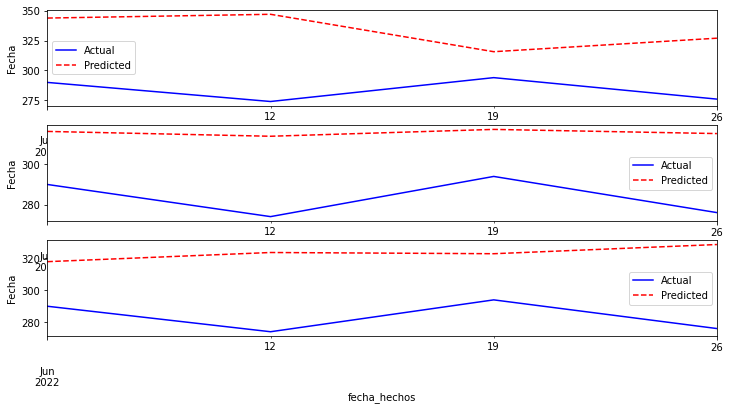

In [136]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,1,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [145]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 2832.571092340164%
MAPE: 17.79168759671719%
sMAPE: 4.038473826469368%
Errores de la Red LSTM:
MSE: 1097.5712612716015%
MAPE: 11.47646764929978%
sMAPE: 2.704042863372834%
Errores de la Red GRU:
MSE: 1719.17255467223
MAPE: 14.190117459265988%
sMAPE: 3.292329671159023%


**Serie por hora**

In [111]:
in_dim = 120
out_dim = 48
bach_size = 1
torch.manual_seed(20)
print_losses = False
hidden = 4
layers = 2
hour_ts = True

In [112]:
train,val,test = hour_databases("/content/drive/My Drive/Delitos_filtrados/robo_objetos.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 48])) that is different to the input size (torch.Size([120, 48])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


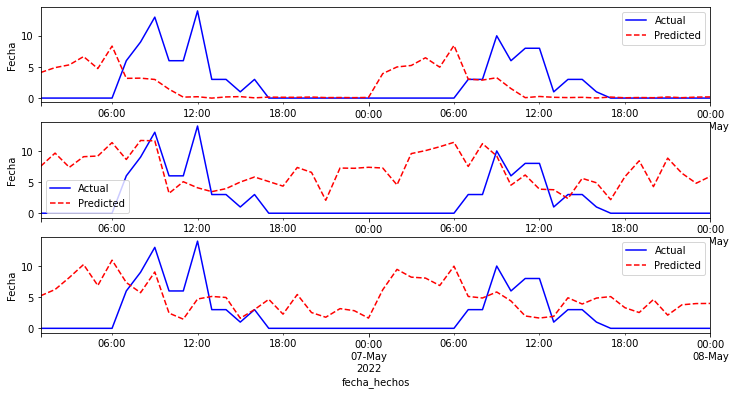

In [113]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,1,device,n_epochs=100,tol=10)
device='cpu'
Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [110]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 19.988813656907286%
MAPE: 84.3692800190222%
sMAPE: 38.930222185391216%
Errores de la Red LSTM:
MSE: 137.00365330496348%
MAPE: 335.0341847120514%
sMAPE: 22.967983261673933%
Errores de la Red GRU:
MSE: 89.14767130560494
MAPE: 187.9597603745681%
sMAPE: 18.11467188476646%


### **Violencia Familiar**

In [146]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/violencia_familiar.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


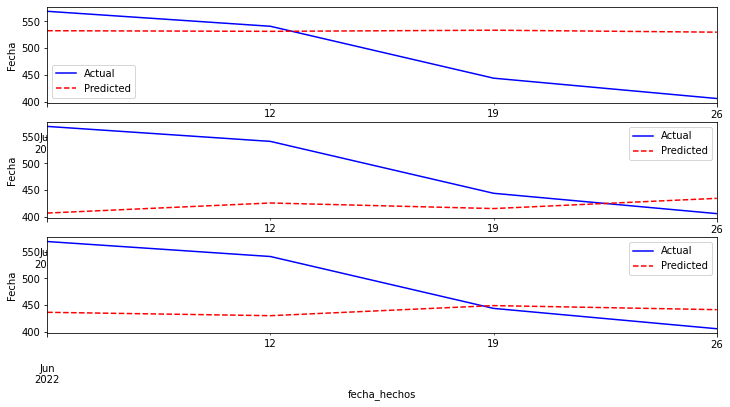

In [147]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,2,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [148]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 6203.876868041232%
MAPE: 14.71472272454723%
sMAPE: 3.324265701763192%
Errores de la Red LSTM:
MSE: 10279.10457336693%
MAPE: 15.80155933497881%
sMAPE: 4.402392877752834%
Errores de la Red GRU:
MSE: 7758.089239760069
MAPE: 13.414946499912636%
sMAPE: 3.666829341737575%


### **Robo transeuntes**

In [149]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_transeuntes.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


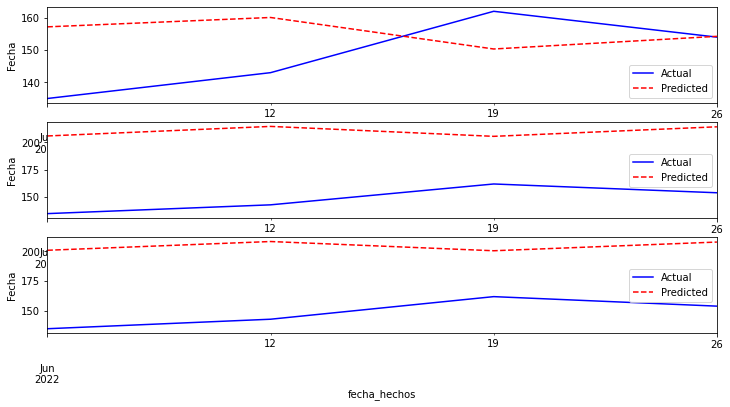

In [150]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,3,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [151]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 230.04903713229578%
MAPE: 8.93620954626865%
sMAPE: 2.1308266164273184%
Errores de la Red LSTM:
MSE: 3900.7029755125986%
MAPE: 42.04260159970253%
sMAPE: 8.610702761130828%
Errores de la Red GRU:
MSE: 3254.702466058079
MAPE: 38.34892321220446%
sMAPE: 7.971792645355061%


### **Fraude**

In [152]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/fraude.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


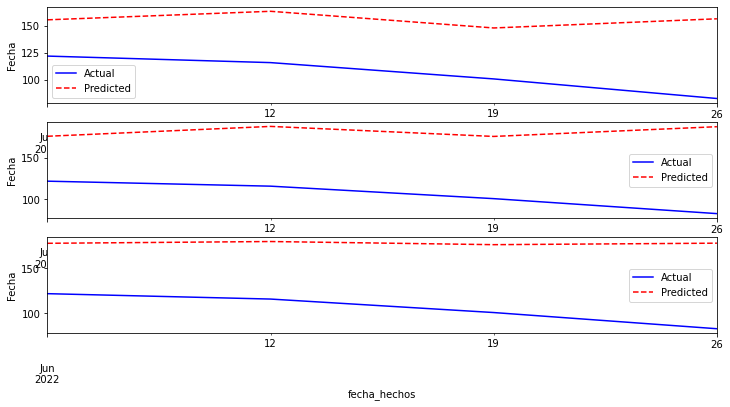

In [153]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,4,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [154]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 2725.2674589266535%
MAPE: 50.665503973815994%
sMAPE: 9.796005797573478%
Errores de la Red LSTM:
MSE: 6143.674342377984%
MAPE: 76.51107167669431%
sMAPE: 13.423867652776591%
Errores de la Red GRU:
MSE: 5495.18446657178
MAPE: 72.60814463503986%
sMAPE: 12.990250121967826%


### **Robo a negocia sin violencia**

In [155]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_neg_sin.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


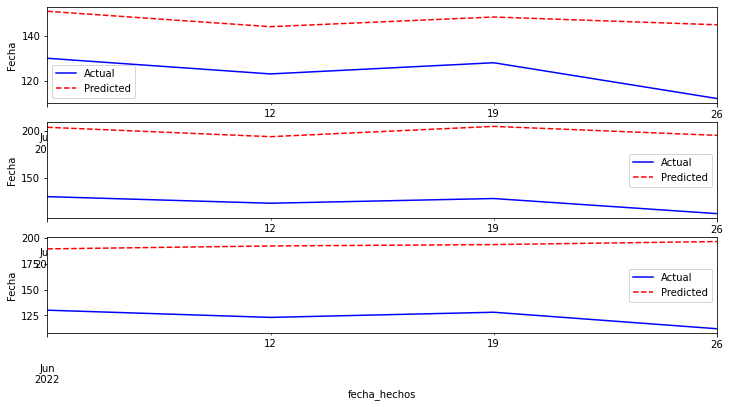

In [156]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,5,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [157]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 598.9720919326646%
MAPE: 19.699880253168466%
sMAPE: 4.454082490673635%
Errores de la Red LSTM:
MSE: 5781.200547920307%
MAPE: 61.948397042688896%
sMAPE: 11.79719412243295%
Errores de la Red GRU:
MSE: 4955.945466078003
MAPE: 57.25327046027423%
sMAPE: 11.056083852290513%


### **Amenazas** 

In [158]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/amenazas.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


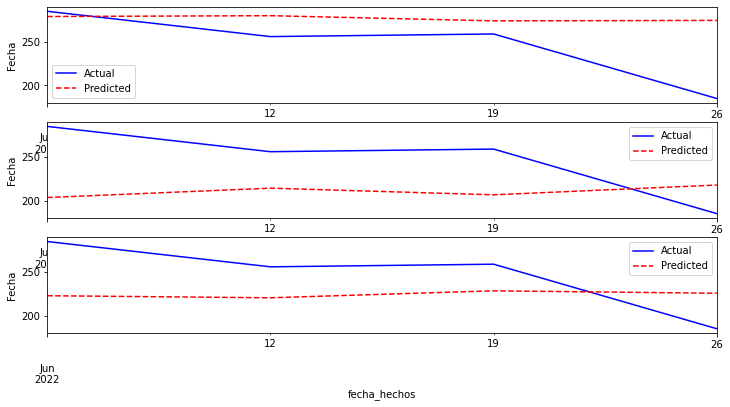

In [159]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,6,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [160]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 2213.3275430561043%
MAPE: 16.415099044774095%
sMAPE: 3.479369469960733%
Errores de la Red LSTM:
MSE: 3056.3045620985213%
MAPE: 20.72875859632342%
sMAPE: 5.62407752526717%
Errores de la Red GRU:
MSE: 1927.9090799990809
MAPE: 17.365441648490805%
sMAPE: 4.482645111926025%


                                              
### **ROBO DE VEHICULO CON Y SIN VIOLENCIA**


In [161]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_carros.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


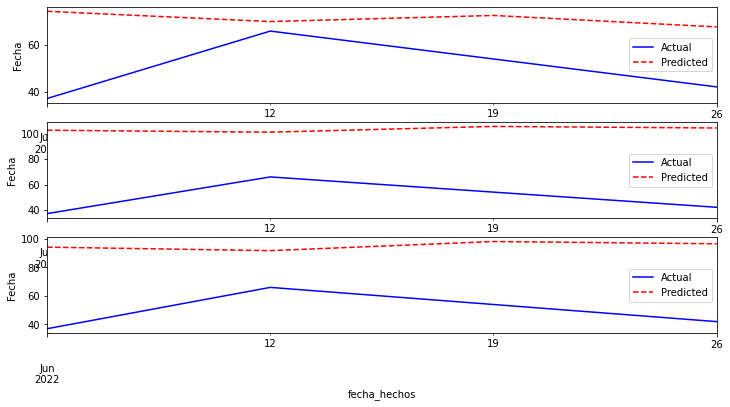

In [162]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,7,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [163]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 609.9097887745593%
MAPE: 50.915933145356675%
sMAPE: 9.363990824390331%
Errores de la Red LSTM:
MSE: 3055.3102636550466%
MAPE: 119.28543656382173%
sMAPE: 17.93064183312097%
Errores de la Red GRU:
MSE: 2218.058150149416
MAPE: 101.38390469429899%
sMAPE: 16.04630257265499%


### **ROBO A CASA SIN VIOLENCIA**


In [164]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_casa_sin.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


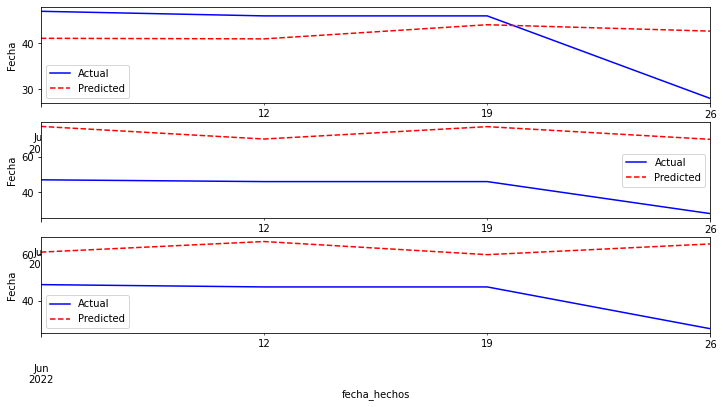

In [165]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,8,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [166]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 69.74359385362914%
MAPE: 20.007578491991318%
sMAPE: 4.41814945277672%
Errores de la Red LSTM:
MSE: 1042.6919649428019%
MAPE: 83.03605652208354%
sMAPE: 14.086593087236244%
Errores de la Red GRU:
MSE: 526.1751904491284
MAPE: 58.22743600089405%
sMAPE: 10.38518605114906%


### **ROBO A PASAJERO A BORDO DE OTROS TRANSPORTE CON Y SIN VIOLENCIA**

In [167]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/robo_pasajeros.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


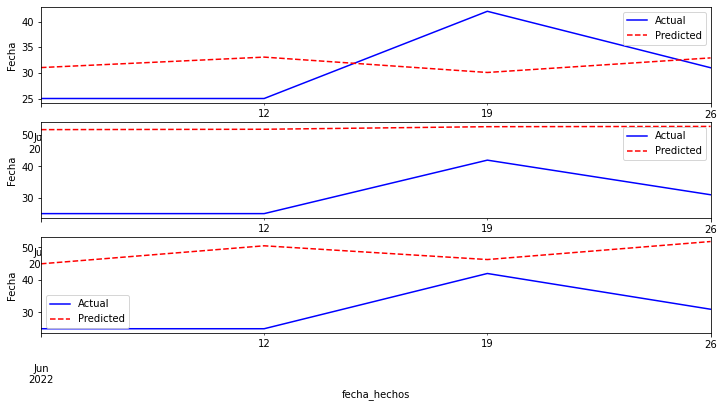

In [168]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,9,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [169]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 61.841049800824294%
MAPE: 22.741624353118755%
sMAPE: 5.525037356075393%
Errores de la Red LSTM:
MSE: 504.2887002979551%
MAPE: 77.36849168991347%
sMAPE: 13.363573101113314%
Errores de la Red GRU:
MSE: 375.72755086078905
MAPE: 64.85431703371202%
sMAPE: 11.544120436153829%


### **OTROS DELITOS DE INDOLE SEXUA**

In [170]:
train,val,test = week_databases("/content/drive/My Drive/Delitos_filtrados/sexuales.csv")
X_train_dataloader, X_val_dataloader, X_test_dataloader,scaler = prepare_dataloaders(train,val,test,bach_size,in_dim,out_dim)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([4, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


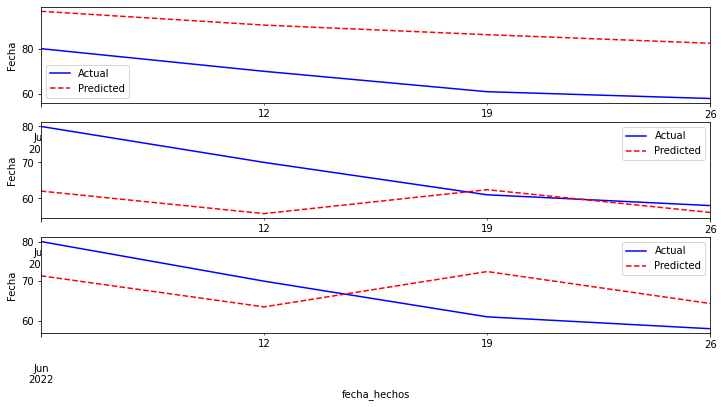

In [171]:
rnn_net,lstm_net, gru_net = NN_train(X_train_dataloader, X_val_dataloader,bach_size,hidden,layers,
                                     in_dim,out_dim,9,'cpu')

Forecasting_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

In [172]:
Error_delitos(rnn_net,lstm_net, gru_net,X_test_dataloader,test,scaler)

Errores de la Red neuronal recurrente:
MSE: 478.9789271342888%
MAPE: 33.262402728292614%
sMAPE: 7.066257793910347%
Errores de la Red LSTM:
MSE: 132.73526881936414%
MAPE: 12.102932388000994%
sMAPE: 3.348841541296208%
Errores de la Red GRU:
MSE: 71.92557674423733
MAPE: 12.439869324475355%
sMAPE: 3.04090644237739%
